In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
cell222 = pd.read_csv('forcas_qe_base.csv')

In [4]:
cell222

,sim_id,atom_id,atom_type,fx_Ry_bohr,fy_Ry_bohr,fz_Ry_bohr,modulo_Ry_bohr,modulo_eV_A,energia_total_Ry
0,ZnO-3.27-1.61-222,1,1,2.900000e-07,1.700000e-07,5.986000e-05,5.986094e-05,0.001539,-2893.095103
1,ZnO-3.27-1.61-222,2,1,0.000000e+00,2.700000e-07,6.109000e-05,6.109060e-05,0.001571,-2893.095103
2,ZnO-3.27-1.61-222,3,2,3.200000e-07,1.900000e-07,-6.067000e-05,6.067114e-05,0.001560,-2893.095103
3,ZnO-3.27-1.61-222,4,2,-0.000000e+00,-4.700000e-07,-5.992000e-05,5.992184e-05,0.001541,-2893.095103
4,ZnO-3.27-1.61-222,5,1,-2.500000e-07,-1.400000e-07,6.357000e-05,6.357065e-05,0.001634,-2893.095103
...,...,...,...,...,...,...,...,...,...
27099,ZnO-3.53-1.58-222,28,2,1.000000e-08,1.000000e-08,-1.920000e-06,1.920052e-06,0.000049,-2893.095103
27100,ZnO-3.53-1.58-222,29,1,-0.000000e+00,1.300000e-07,3.950000e-06,3.952139e-06,0.000102,-2893.095103
27101,ZnO-3.53-1.58-222,30,1,-4.190000e-06,-2.420000e-06,-3.660000e-06,6.066968e-06,0.000156,-2893.095103
27102,ZnO-3.53-1.58-222,31,2,0.000000e+00,-2.900000e-07,1.600000e-07,3.312099e-07,0.000009,-2893.095103


In [7]:
import seaborn as sns
# from sklearn.decomposition import PCA

In [8]:
sns.set(style="whitegrid")

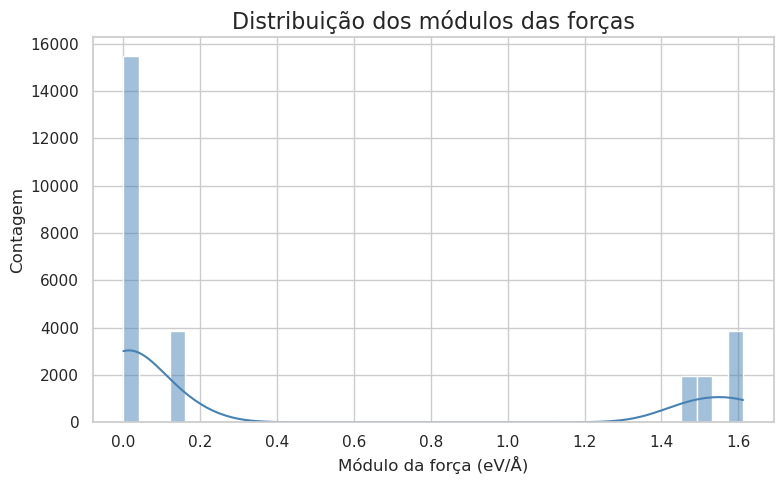

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(cell222["modulo_eV_A"], bins=40, kde=True, color="steelblue")
plt.xlabel("Módulo da força (eV/Å)")
plt.ylabel("Contagem")
plt.title("Distribuição dos módulos das forças", fontsize=16)
plt.tight_layout()
plt.show()


<h1 style="text-align:center"> <font color="red" size=10> EXTRAÇÃO DE FORÇA "CORRIGIDA" </font></h1>

In [38]:
def extrair_forcas_convergidas(texto):
    # Extrai apenas o primeiro bloco entre os marcadores desejados
    padrao_bloco = re.search(
        r"Forces acting on atoms \(cartesian axes, Ry/au\):\n(.*?)\n\s*The non-local contrib\.  to forces",
        texto, re.DOTALL
    )
    if not padrao_bloco:
        return []

    bloco = padrao_bloco.group(1)
    print(bloco)
    linhas = bloco.strip().splitlines()

    dados = []
    for linha in linhas:
        partes = linha.strip().split()
        if len(partes) != 9:
            continue  # ignora linhas mal formatadas
        atom_id = int(partes[1])
        atom_type = int(partes[3])
        fx, fy, fz = map(float, partes[6:9])
        modulo = np.linalg.norm([fx, fy, fz])
        dados.append({
            "atom_id": atom_id,
            "atom_type": atom_type,
            "fx_Ry_bohr": fx,
            "fy_Ry_bohr": fy,
            "fz_Ry_bohr": fz,
            "modulo_Ry_bohr": modulo,
            "modulo_eV_A": modulo * 25.711,
        })
    return dados

def extrair_dados_qe(path):
    todos_dados = []
    arquivos = glob.glob(path + "/*.out")

    for arq in arquivos:
        with open(arq, 'r') as f:
            texto = f.read()

        sim_id = arq.split("/")[-1].replace(".out", "")

        # Energia total
        energia = None
        m_energia = re.search(r'!\s+total energy\s+=\s+([-\d.]+)', texto)
        if m_energia:
            energia = float(m_energia.group(1))

        # Forças convergidas
        forcas = extrair_forcas_convergidas(texto)

        for dado in forcas:
            dado["sim_id"] = sim_id
            dado["energia_total_Ry"] = energia
            todos_dados.append(dado)

    return pd.DataFrame(todos_dados)